In [1]:
% matplotlib inline

from __future__ import division
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend
from scipy.spatial.distance import pdist, squareform
import scipy.signal as signal
import time as tm
import gsw as sw
from scipy.optimize import curve_fit
from scipy.stats import chi2

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [2]:
def convert_KM(sds):
    lon_tmp = sds[(sds['cruise']=='KiloMoana_1')]['lon']
    lon_tmp = lon_tmp//100 + (lon_tmp - lon_tmp//100*100)/60
    lat_tmp = sds[(sds['cruise']=='KiloMoana_1')]['lat']
    lat_tmp = lat_tmp//100 + (lat_tmp - lat_tmp//100*100)/60
    
    sds.loc[sds['cruise']=='KiloMoana_1','lon'] = -lon_tmp
    sds.loc[sds['cruise']=='KiloMoana_1','lat'] = lat_tmp
    
    lon_tmp2 = sds[(sds['cruise']=='SCOPE_2')]['lon']
    lon_tmp2 = lon_tmp2//100 + (lon_tmp2 - lon_tmp2//100*100)/60
    lat_tmp2 = sds[(sds['cruise']=='SCOPE_2')]['lat']
    lat_tmp2 = lat_tmp2//100 + (lat_tmp2 - lat_tmp2//100*100)/60
    
    sds.loc[sds['cruise']=='SCOPE_2','lon'] = -lon_tmp2
    sds.loc[sds['cruise']=='SCOPE_2','lat'] = lat_tmp2
    
    return sds

def checklon(data):
    cxx = (data['lon']).values # longitude

    # convert all longitude to longitude east
    cxx[cxx<0]= 360+cxx[cxx<0];
    data['lon_e'] = cxx
    cxbew = cxx
    cxbew[cxbew>180] = cxbew[cxbew>180]-360   
    data['lon'] = cxbew
    return data

def distance(data):
    cruise = pd.unique(data['cruise'])
    distances = pd.DataFrame()    
    for c in cruise:
        temp = pd.DataFrame()
        temp = data.loc[(data['cruise']==c), ['cruise','file_time','lon','lat']]
        
        # calculate distance in km between points
        temp['dx'] = np.insert(sw.distance(temp['lon'].values, temp['lat'].values, 0),0,0)/1000
        temp['x'] = np.cumsum(temp['dx'])
        
        if c == cruise[0]:
            distances = distances.append(temp)
        else:
            distances = pd.concat([distances, temp], axis=0)
        del temp
    data = pd.merge(left = data, right = distances, how='left', left_on=['cruise','file_time','lat','lon'], right_on=['cruise','file_time','lat','lon'])
    #return distances

    return data  

def tracks(data):
    seg = []
    start = 0
    n = 1
    for i in range(len(data)):
        if ((data['dx'][i] > 20) | (data['dx'][i] < 0.01)):
            seg.append([data['cruise'][i], start, i-1, sum(data['dx'][start:i-1])])# - data['x'][start])])
                                                         
            n += 1
            start = i+1
    
    segments = pd.DataFrame(seg, columns = ['cruise', 'start', 'end', 'length']) 
    segments = segments.loc[(segments['length'] >= 200)]
    segments = segments.loc[(segments['end'] > 0)]
    segments['number'] = range(1, len(segments)+1)
    segments = segments.set_index(['number'])
    return segments


def interpdata(track, aa, bb, var):
    # we went to create a new dataframe which has the interpolated data for each track for all variables, 
    # and a position.
    intdata = pd.DataFrame()
    # set the interpolation distance 
    n = 1 # 1km 
    begin = np.floor(track['x'][:1])
    intdata['x'] = np.arange(aa, bb, n)
 
    for v in var:
        intdata[v] = np.interp(intdata['x'].values,track['x'].values,track[v].values)
          
    return intdata


In [3]:
# import data
filePath = '/Users/archie/Google Drive/seaflow_data/KM1_abun_sds_opp.csv'
data = pd.read_csv(filePath, sep=',')

filePath = r'/Users/archie/Google Drive/seaflow_data/sds_depth.csv'
depth = pd.read_csv(filePath)

filePath = r'/Users/archie/Google Drive/seaflow_data/sds_dist2coast.csv'
dcoast = pd.read_csv(filePath)

filePath = '/Users/archie/Google Drive/seaflow_data/KM1_chl.csv'
chl = pd.read_csv(filePath, sep=',')

In [4]:
# add density 
data['density'] = sw.rho(data['salinity'].values,data['ocean_tmp'].values,0)
data = checklon(data)

# only keep KM1304 data
data = data[(data['cruise']=='KiloMoana_1')]
               
# sort the dataframe so that it is in date/time order
data = pd.merge(data, depth, on=['cruise','file_time'], how='inner')
data = pd.merge(data, dcoast, on=['cruise','file_time'], how='inner')
data = pd.merge(data, chl, on=['cruise','file_time'], how='inner')
data = data.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
data = data.reset_index(drop=True)

# now we have a dataframe with the total alongtrack distance for each cruise, 
# and the distance between points for each file.

clean = data[['cruise', 'file_time', 'lon', 'lon_e', 'lat', 'depth', 'dcoast', 'salinity', 'ocean_tmp', 'density', 'pico', 'synecho', 'picoeuk', 'chl']]
clean['tot_chl'] = data['tot_chl']#/(data['file_duration']*data['opp.evt']*data['flow_rate'])
clean = clean.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
clean = distance(clean)

segments = tracks(clean)

/Users/archie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
# identify location of fronts along the tracks
# look at what Oliver did in model paper (Levy et al, 2015)

crit = [0.025, 0.05, 0.0625] # density change criterion, density/km

# calculate running mean of density change over the track
dx = 10 # length scale to averge the desnity change over

front = pd.DataFrame()#columns = ['lat', 'lon', 'level'])

for i in range(len(clean)):
    init = clean['x'][i]
    #print init
    tmp = clean[(clean['x'] <= init + 20) & (clean['x']>= init)]
    dx = np.mean(np.abs(np.diff(tmp['x'])))
    print dx
    if len(tmp)>= 15 and dx > 0.:
        drho = np.mean(np.abs(np.diff(tmp['density'])))
        dtmp = np.mean(np.abs(np.diff(tmp['ocean_tmp'])))
        dsal = np.mean(np.abs(np.diff(tmp['salinity'])))

        if (dtmp >= crit[0] and dtmp < crit[1]):
            level = 1
        elif (dtmp >= crit[1]):
            level = 2
        elif (dtmp >= crit[2]):
            level = 3
        else: 
            level = 0

        lon = np.mean(tmp['lon'])
        lat = np.mean(tmp['lat'])
        x = np.mean(tmp['x'])
        dx = np.sum(np.abs(tmp['dx']))

        front = front.append(pd.Series([lat, lon, x, dtmp, level, dx]),ignore_index=True)
                           

front.rename(columns={0: 'lat', 1: 'lon', 2 : 'x', 3 : 'dtmp', 4: 'level', 5 : 'dx'}, inplace=True)

1.04506598314
1.04930995931
1.05455318937
1.05880125015
1.06423406591
1.07011188598
1.07316397541
1.07716689867
1.08381469712
1.08778692013
1.09467961501
1.10017896487
1.10532179504
1.11005725517
1.11022145899
1.1142694732
1.1198295353
1.12609423519
1.13110262958
1.1371805137
1.14303296969
1.14740236531
1.1527378935
1.158966834
1.16213807348
1.16681211506
1.1721436947
1.17326305901
1.18420286131
1.18497265689
1.18661779208
1.19255422211
1.19791007619
1.20384692158
1.20527036693
1.20858113862
1.21460487692
1.2162879269
1.22658016982
3.32207616571
3.74534110028
3.78894596692
3.81972347472
3.84872955748
3.85536910928
1.23206403151
1.23012928897
1.22209690231
1.21466926321
1.20228737343
1.19587601929
1.19508026421
1.21796699435
1.21866341573
1.21611165998
1.21286707118
1.21848783225
1.21979022184
1.22503638644
1.22470488286
1.22767167997
1.22993114286
1.22136147261
1.22487517016
1.226613117
1.22907488196
1.23681780939
1.24490494819
1.24549423139
1.24648942192
1.25534953702
1.25991749762
1.

In [ ]:
fig = plt.figure(1, figsize=(18, 9), dpi = 600)

plt.plot(clean['x'],clean['ocean_tmp'],'r')
plt.plot(front['x'], front['level']+21,'.k')
plt.plot(front['x'], front['dtmp']*100, '.b')


plt.axis([0, 4000, 0, 30])
plt.show()


In [ ]:
print len(front[front['level']>0])/len(clean)
print len(front[front['level']>1])/len(clean)
print len(front[front['level']>2])/len(clean)

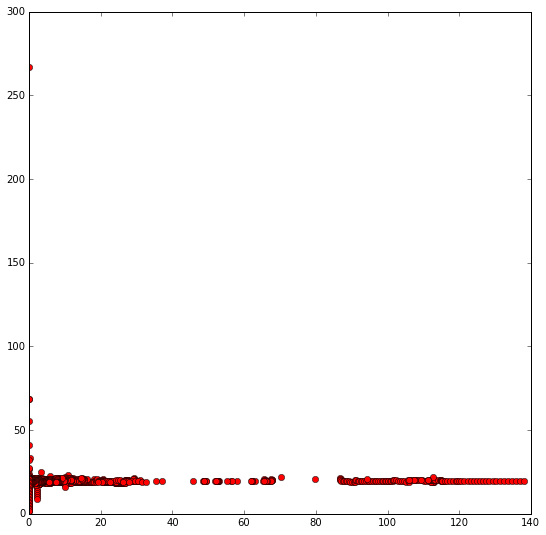

inf 0.000140768316817 inf


In [39]:
fig = plt.figure(1, figsize=(9, 9), dpi = 600)

plt.plot(front['dtmp'], front['dx'], 'or')
plt.show()

print np.max(front['dtmp']), np.min(front['dtmp']), np.mean(front['dtmp'])